<a href="https://colab.research.google.com/github/UnitForDataScience/Projects-Fall-2024/blob/main/RetinoVision/FGADR_Seg_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


 # Diabetic Retonpathy


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#drive.flush_and_unmount()

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

import os
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint

## Binary Classification

In [3]:
# Define directory paths
base_dir = '/content/drive/MyDrive/Projects /Projects-Fall-2024/RetinoVision/FGADR-Seg-set_Release/Seg-set/'
images_dir = os.path.join(base_dir, 'Original_Images')
labels_csv_path = os.path.join(base_dir, 'labels.csv')

df_labels = pd.read_csv(labels_csv_path)
df_labels['binary'] = df_labels['binary'].astype(str)

# Create image data generator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

In [4]:
# Prepare training data generator
train_generator = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=images_dir,
    x_col='name',
    y_col='binary',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True
)

# Prepare validation data generator
validation_generator = datagen.flow_from_dataframe(
    dataframe=df_labels,
    directory=images_dir,
    x_col='name',
    y_col='binary',
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=True
)

Found 1474 validated image filenames belonging to 2 classes.
Found 368 validated image filenames belonging to 2 classes.


In [5]:
# Build CNN model for binary classification
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # 1 neuron for binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Compile model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])

In [7]:
# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      18,940,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,034,177 (72.61 MB)

 Trainable params: 19,034,177 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 663s 12s/step - accuracy: 0.9433 - loss: 0.4308 - val_accuracy: 0.9511 - val_loss: 0.1741
Epoch 2/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 149s 2s/step - accuracy: 0.9427 - loss: 0.1975 - val_accuracy: 0.9511 - val_loss: 0.1639
Epoch 3/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 122s 2s/step - accuracy: 0.9385 - loss: 0.2240 - val_accuracy: 0.9511 - val_loss: 0.1719
Epoch 4/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 121s 2s/step - accuracy: 0.9405 - loss: 0.2180 - val_accuracy: 0.9511 - val_loss: 0.1651
Epoch 5/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 119s 2s/step - accuracy: 0.9401 - loss: 0.2026 - val_accuracy: 0.9511 - val_loss: 0.1718
Epoch 6/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 114s 2s/step - accuracy: 0.9417 - loss: 0.2028 - val_accuracy: 0.9511 - val_loss: 0.1604
Epoch 7/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 142s 2s/step - accuracy: 0.9475 - loss: 0.1735 - val_accuracy: 0.9511 - val_loss: 0.1651
Epoch 8/10
47/47 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.9288 - loss: 0.2227 - val_accuracy: 0.9511 - val_loss: 0

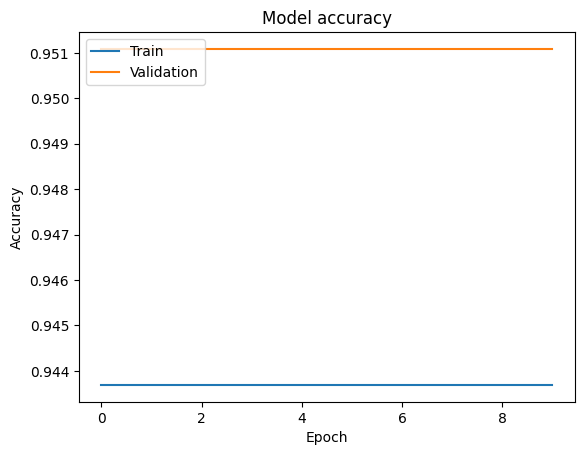

In [9]:
# Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

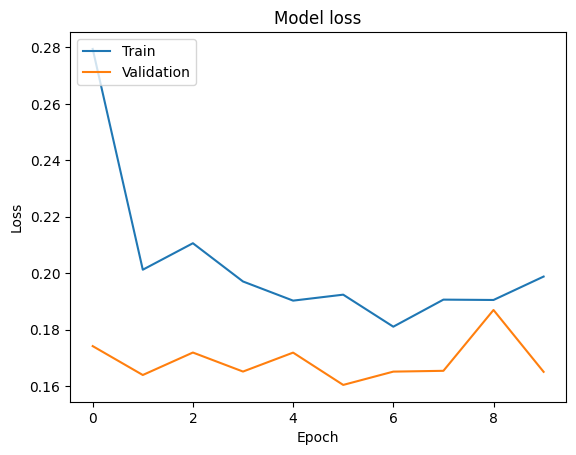

In [10]:
# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()